# Model performance in production: all GB

This document contains the code used to compute performance scores of all the models used for the case of GB. It is the production version of [`explore_model_performance`](explore_model_performance).

In [1]:
import os, warnings
import pandas
import geopandas
import numpy as np
import statsmodels.formula.api as sm
from statsmodels.iolib.summary2 import summary_col
from libpysal import weights
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy

import tools_chip_prob_modelling as tools

data_p = '/home/jovyan/data/spatial_signatures/chip_probs/prod_model_outputs/'

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


## Compile preditions

For every pair of `(chipsize, arch)`, we have:

- 1 x unique geography
- 1 x set of true labels
- 5 x sets of predictions by different `(algo, variant)`

In each of these `(chipsize, arch)` blocks, we compile the data in a single table:

```
id | label | split | geometry | preds1 | preds2 | preds3 | preds4 | preds5
```

We then assemble all the tables in a single one, tagging each observation with the block they belong to.

In [2]:
ps = ! ls $data_p*_y_pred.pq
db = []
for chipsize in [8, 16, 32, 64]:
    for arch in ['bic', 'sic', 'mor']:
        db.append(tools.compile_chipsize_arch(chipsize, arch, ps))
db = pandas.concat(db)
db.iloc[:, 4:] = db.iloc[:, 4:].apply(
    lambda x: pandas.Categorical(x, categories=tools.class_names)
)

db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2552961 entries, 1 to 94959
Data columns (total 9 columns):
 #   Column                                      Dtype   
---  ------                                      -----   
 0   geometry                                    geometry
 1   label                                       category
 2   split                                       object  
 3   chipsize_arch                               object  
 4   HistGradientBoostingClassifier_baseline-wx  category
 5   HistGradientBoostingClassifier_baseline     category
 6   logite_baseline-wx                          category
 7   logite_baseline                             category
 8   maxprob                                     category
dtypes: category(6), geometry(1), object(2)
memory usage: 92.5+ MB


## Non-spatial scores

In [17]:
def nss(sub_db):
    metas = {}
    models = sub_db.drop(
        columns=['label', 'split', 'chipsize_arch']
    ).columns
    for model in models:
        sub_train = sub_db.query('split == "ml_train"')
        sub_val = sub_db.query('split == "ml_val"')
        res = tools.build_perf(
            sub_train['label'],
            sub_train[model],
            sub_val['label'],
            sub_val[model],
            tools.class_names
        )
        metas[model] = deepcopy(res)
        del res
    return metas

def nss_dask(params):
    uid, sub_db = params
    return pandas.Series({uid: nss(sub_db)})

In [31]:
from dask import bag as dbag
from dask.distributed import Client, LocalCluster

client = Client(LocalCluster(n_workers=12))

In [32]:
%%time
tasks = [
    (csa, db.query(
        f'chipsize_arch == "{csa}"'
    )[
        [c for c in db.columns if c != 'geometry']
    ]) for csa in db['chipsize_arch'].unique()
]
out = pandas.concat(dbag.from_sequence(tasks).map(nss_dask).compute())

def parse_metas(metas):
    metass = {}
    for csarch in metas.index:
        for i in metas[csarch]:
            metass[f'{csarch}_{i}'] = metas[csarch][i]
    return pandas.Series(metass)

metrics = parse_metas(out)

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


CPU times: user 11 s, sys: 1.45 s, total: 12.5 s
Wall time: 1min 8s


In [33]:
client.shutdown()

### Single scores

#### Summary stats

In [34]:
global_scores = []
for csam in metrics.index:
    global_scores.append(pandas.Series(
        {i.replace('perf_', '').replace('_val', ''): metrics[csam][i] for i in [
            'perf_kappa_val', 
            'perf_model_accuracy_val', 
            'perf_macro_f1_avg_val',
            'perf_macro_f1_w_val'
        ]},
        name=csam
    ))
global_scores = pandas.concat(
    global_scores, axis=1
).T
global_scores = global_scores.reset_index()
global_scores['chipsize'] = global_scores['index'].apply(lambda i: i.split('_')[0])
global_scores['arch'] = global_scores['index'].apply(lambda i: i.split('_')[1])
global_scores['model'] = global_scores['index'].apply(lambda i: '_'.join(i.split('_')[2:]))
global_scores = global_scores.set_index(
    ['arch', 'chipsize', 'model']
).drop(columns='index').sort_index()
global_scores

kappa  \
arch chipsize model                                                  
bic  16       HistGradientBoostingClassifier_baseline     0.275749   
              HistGradientBoostingClassifier_baseline-wx  0.361682   
              logite_baseline                             0.262573   
              logite_baseline-wx                          0.338490   
              maxprob                                     0.187177   
     32       HistGradientBoostingClassifier_baseline     0.315048   
              HistGradientBoostingClassifier_baseline-wx  0.402603   
              logite_baseline                             0.312078   
              logite_baseline-wx                          0.385497   
              maxprob                                     0.265221   
     64       HistGradientBoostingClassifier_baseline     0.427996   
              HistGradientBoostingClassifier_baseline-wx  0.526936   
              logite_baseline                             0.412455   
              logite_baseline-wx                          0.507401   
              maxprob                                     0.319494   
     8        HistGradientBoostingClassifier_baseline     0.246007   
              HistGradientBoostingClassifier_baseline-wx  0.280855   
              logite_baseline                             0.247200   
              logite_baseline-wx                          0.274374   
              maxprob                                     0.231938   
mor  16       HistGradientBoostingClassifier_baseline     0.254643   
              HistGradientBoostingClassifier_baseline-wx  0.269200   
              logite_baseline                             0.236548   
              logite_baseline-wx                          0.265856   
              maxprob                                     0.212690   
     32       HistGradientBoostingClassifier_baseline     0.439503   
              HistGradientBoostingClassifier_baseline-wx  0.338734   
              logite_baseline                             0.298071   
              logite_baseline-wx                          0.326147   
              maxprob                                     0.284674   
     64       HistGradientBoostingClassifier_baseline     0.681270   
              HistGradientBoostingClassifier_baseline-wx  0.589544   
              logite_baseline                             0.530732   
              logite_baseline-wx                          0.542034   
              maxprob                                     0.534811   
     8        HistGradientBoostingClassifier_baseline     0.234621   
              HistGradientBoostingClassifier_baseline-wx  0.273241   
              logite_baseline                             0.235271   
              logite_baseline-wx                          0.262831   
              maxprob                                     0.224009   
sic  16       HistGradientBoostingClassifier_baseline     0.302856   
              HistGradientBoostingClassifier_baseline-wx  0.414653   
              logite_baseline                             0.302232   
              logite_baseline-wx                          0.409139   
              maxprob                                     0.292997   
     32       HistGradientBoostingClassifier_baseline     0.333789   
              HistGradientBoostingClassifier_baseline-wx  0.444575   
              logite_baseline                             0.301006   
              logite_baseline-wx                          0.432935   
              maxprob                                     0.280813   
     64       HistGradientBoostingClassifier_baseline     0.364752   
              HistGradientBoostingClassifier_baseline-wx  0.466725   
              logite_baseline                             0.357339   
              logite_baseline-wx                          0.454303   
              maxprob                                     0.347160   
     8        HistGradientBoostingClassifier_baseline     0.277495   
 

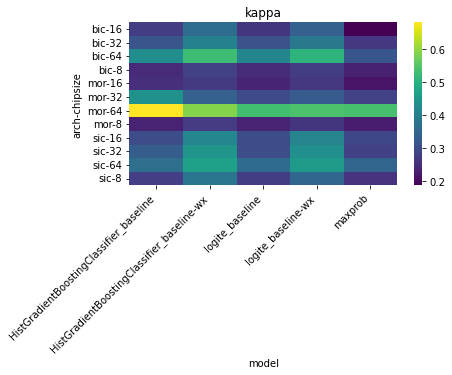

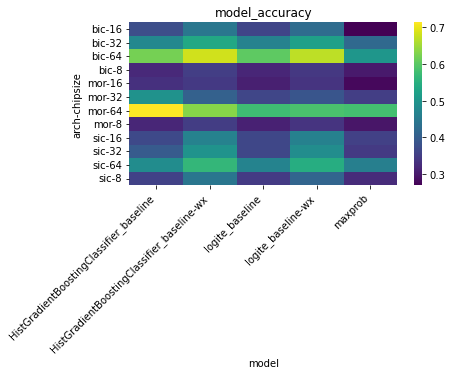

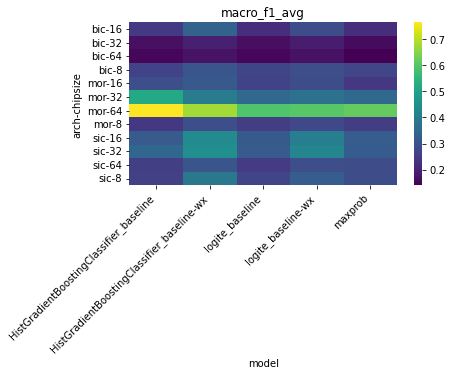

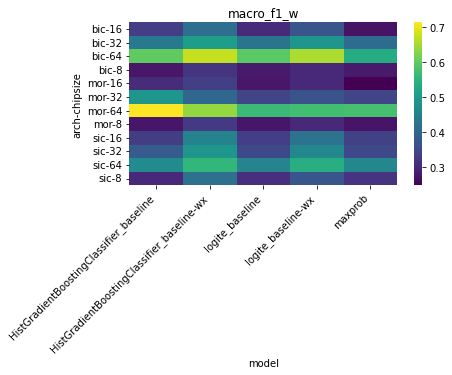

In [35]:
for score in global_scores:
    f, ax = plt.subplots(1, figsize=(6, 3))
    h = sns.heatmap(global_scores[score].unstack(), cmap='viridis', ax=ax)
    h.set_xticklabels(h.get_xticklabels(), rotation = 45, ha="right")
    h.set_title(score);

#### Regression models

In [36]:
mdb = global_scores.reset_index()
mdb['algo'] = mdb['model'].apply(lambda s: s.split('_')[0])
mdb['w'] = mdb['model'].str.contains('wx').astype(int)
mdb['chipsize_int'] = mdb['chipsize'].astype(int)
m1 = sm.ols(
    'kappa ~ arch + chipsize_int + algo + w', mdb
).fit()
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  kappa   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     22.87
Date:                Tue, 23 Aug 2022   Prob (F-statistic):           4.11e-13
Time:                        16:58:02   Log-Likelihood:                 89.169
No. Observations:                  60   AIC:                            -164.3
Df Residuals:                      53   BIC:                            -149.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.2185      0.021     10.466      0.000       0.177       0.260
arch[T.mor]         0.0227      0.018      1.231      0.224      -0.014       0.060
arch[T.sic]         0.0232      0.018      1.259      0.213      -0.014       0.060
algo[T.logite]     -0.0245      0.017     -1.454      0.152      -0.058       0.009
algo[T.maxprob]    -0.0559      0.022     -2.514      0.015      -0.101      -0.011
chipsize_int        0.0036      0.000     10.330      0.000       0.003       0.004
w                   0.0572      0.017      3.401      0.001       0.023       0.091
==============================================================================
Omnibus:                       12.796   Durbin-Watson:                   1.394
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               16.654
Skew:                           0.809   Prob(JB):                     0.000242
Kurtosis:                       5.010   Cond. No.                         146.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
m2 = sm.ols(
    'model_accuracy ~ arch + chipsize_int + algo + w', mdb
).fit()
m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         model_accuracy   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     42.55
Date:                Tue, 23 Aug 2022   Prob (F-statistic):           1.48e-18
Time:                        16:58:03   Log-Likelihood:                 99.621
No. Observations:                  60   AIC:                            -185.2
Df Residuals:                      53   BIC:                            -170.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.3236      0.018     18.451      0.000       0.288       0.359
arch[T.mor]        -0.0357      0.015     -2.305      0.025      -0.067      -0.005
arch[T.sic]        -0.0247      0.015     -1.598      0.116      -0.056       0.006
algo[T.logite]     -0.0256      0.014     -1.814      0.075      -0.054       0.003
algo[T.maxprob]    -0.0606      0.019     -3.240      0.002      -0.098      -0.023
chipsize_int        0.0043      0.000     14.669      0.000       0.004       0.005
w                   0.0468      0.014      3.313      0.002       0.018       0.075
==============================================================================
Omnibus:                        2.329   Durbin-Watson:                   1.319
Prob(Omnibus):                  0.312   Jarque-Bera (JB):                1.573
Skew:                           0.364   Prob(JB):                        0.455
Kurtosis:                       3.314   Cond. No.                         146.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
m3 = sm.ols(
    'macro_f1_w ~ arch + chipsize_int + algo + w', mdb
).fit()
m3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             macro_f1_w   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     50.62
Date:                Tue, 23 Aug 2022   Prob (F-statistic):           3.28e-20
Time:                        16:58:04   Log-Likelihood:                 99.926
No. Observations:                  60   AIC:                            -185.9
Df Residuals:                      53   BIC:                            -171.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.2790      0.017     15.989      0.000       0.244       0.314
arch[T.mor]        -0.0278      0.015     -1.803      0.077      -0.059       0.003
arch[T.sic]        -0.0171      0.015     -1.113      0.271      -0.048       0.014
algo[T.logite]     -0.0324      0.014     -2.303      0.025      -0.061      -0.004
algo[T.maxprob]    -0.0421      0.019     -2.265      0.028      -0.079      -0.005
chipsize_int        0.0048      0.000     16.420      0.000       0.004       0.005
w                   0.0531      0.014      3.781      0.000       0.025       0.081
==============================================================================
Omnibus:                        4.445   Durbin-Watson:                   1.325
Prob(Omnibus):                  0.108   Jarque-Bera (JB):                3.476
Skew:                           0.477   Prob(JB):                        0.176
Kurtosis:                       3.694   Cond. No.                         146.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
m4 = sm.ols(
    'macro_f1_avg ~ arch + chipsize_int + algo + w', mdb
).fit()
m4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           macro_f1_avg   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     6.373
Date:                Tue, 23 Aug 2022   Prob (F-statistic):           4.27e-05
Time:                        16:58:04   Log-Likelihood:                 54.087
No. Observations:                  60   AIC:                            -94.17
Df Residuals:                      53   BIC:                            -79.51
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.1798      0.037      4.799      0.000       0.105       0.255
arch[T.mor]         0.1787      0.033      5.406      0.000       0.112       0.245
arch[T.sic]         0.1101      0.033      3.332      0.002       0.044       0.176
algo[T.logite]     -0.0325      0.030     -1.077      0.286      -0.093       0.028
algo[T.maxprob]    -0.0296      0.040     -0.742      0.461      -0.110       0.050
chipsize_int        0.0014      0.001      2.162      0.035    9.85e-05       0.003
w                   0.0392      0.030      1.301      0.199      -0.021       0.100
==============================================================================
Omnibus:                        6.405   Durbin-Watson:                   0.859
Prob(Omnibus):                  0.041   Jarque-Bera (JB):                5.725
Skew:                           0.741   Prob(JB):                       0.0571
Kurtosis:                       3.302   Cond. No.                         146.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Class-based scores

#### Confusion matrices

2022-08-23 16:58:21,724 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


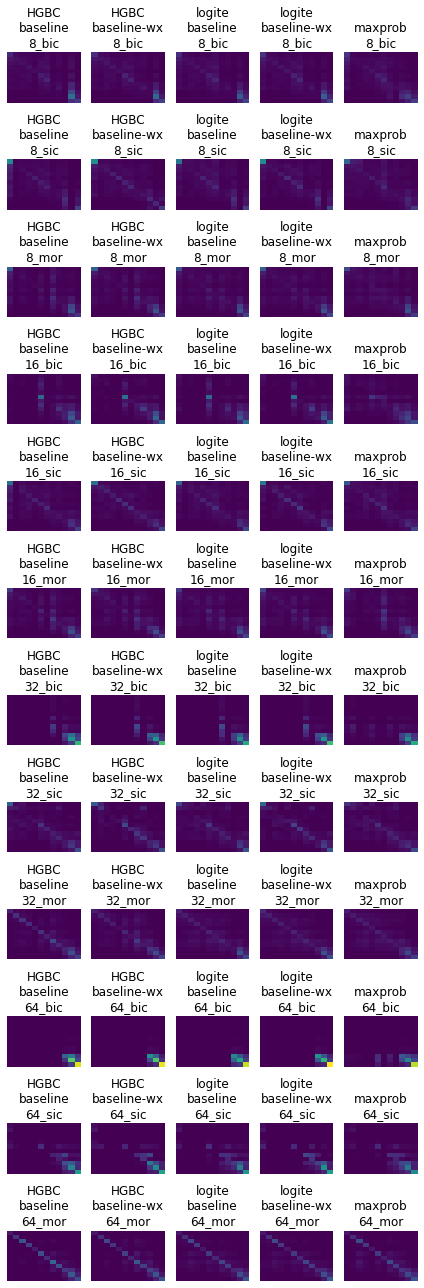

In [40]:
cms = []
for csam in metrics.index:
    csa = '_'.join(csam.split('_')[0:2])
    model = '_'.join(csam.split('_')[2:])
    cm = np.array(metrics[csam]['perf_confusion_val'])
    cm = cm * 100 / cm.sum()
    cms.append({'csa': csa, 'model': model, 'cm': cm})
cms = pandas.DataFrame(cms).pivot('csa', 'model', 'cm')

csa_order = [
    f'{cs}_{a}' for cs in [8, 16, 32, 64] for a in ['bic', 'sic', 'mor']
]

f, axs = plt.subplots(len(csa_order), cms.shape[1], figsize=(6, 18))
maxval = cms.applymap(np.max).values.max()
for csa in range(len(csa_order)):
    for model in range(cms.shape[1]):
        ax = axs[csa, model]
        tools.build_cm_plot(
            cms.loc[csa_order[csa], cms.columns[model]], 
            maxcount=maxval,
            cbar=False,
            ax=ax
        )
        model_title = cms.columns[model].replace(
            'HistGradientBoostingClassifier', 'HGBC'
        ).replace(
            '_', '\n'
        )
        t = f"{model_title}\n{csa_order[csa]}"
        ax.set_title(t)
plt.tight_layout()
plt.show()

To see if there are more interesting patterns, we standardise CMs by chip size and color them accordingly to ensure there is no confusion in terms of comparison across:

In [227]:
# TBA

#### Accuracy

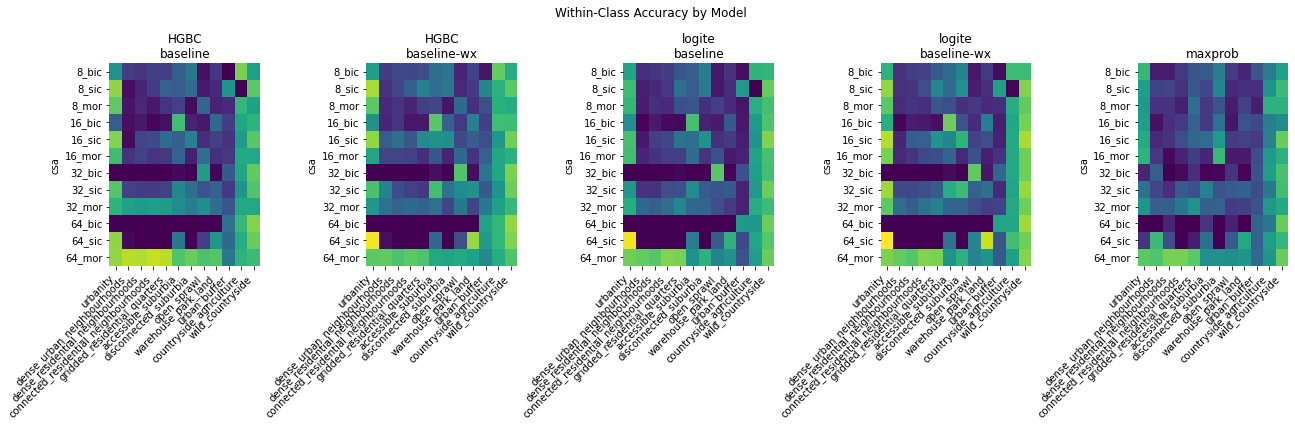

In [41]:
cba = []
for csam in metrics.index:
    csa = '_'.join(csam.split('_')[0:2])
    model = '_'.join(csam.split('_')[2:])
    scores = pandas.Series(
        metrics[csam]['perf_within_class_accuracy_val'],
        metrics[csam]['meta_class_names']
    )
    cba.append({'csa': csa, 'model': model, 'scores': scores})
cba = pandas.DataFrame(cba).pivot('csa', 'model', 'scores')

f, axs = plt.subplots(1, cba.shape[1], figsize=(18, 6))
maxval = cba.applymap(np.max).values.max()
for model in range(cba.shape[1]):
    ax = axs[model]
    h = sns.heatmap(
        pandas.DataFrame(
            cba[cba.columns[model]].tolist(), cba.index
        ).reindex(csa_order), 
        vmax=maxval,
        cbar=False,
        cmap='viridis',
        ax=ax
    )
    h.set_xticklabels(h.get_xticklabels(), rotation = 45, ha="right")
    model_title = cba.columns[model].replace(
        'HistGradientBoostingClassifier', 'HGBC'
    ).replace(
        '_', '\n'
    )
    ax.set_title(model_title)
plt.suptitle('Within-Class Accuracy by Model')
plt.tight_layout()
plt.show()

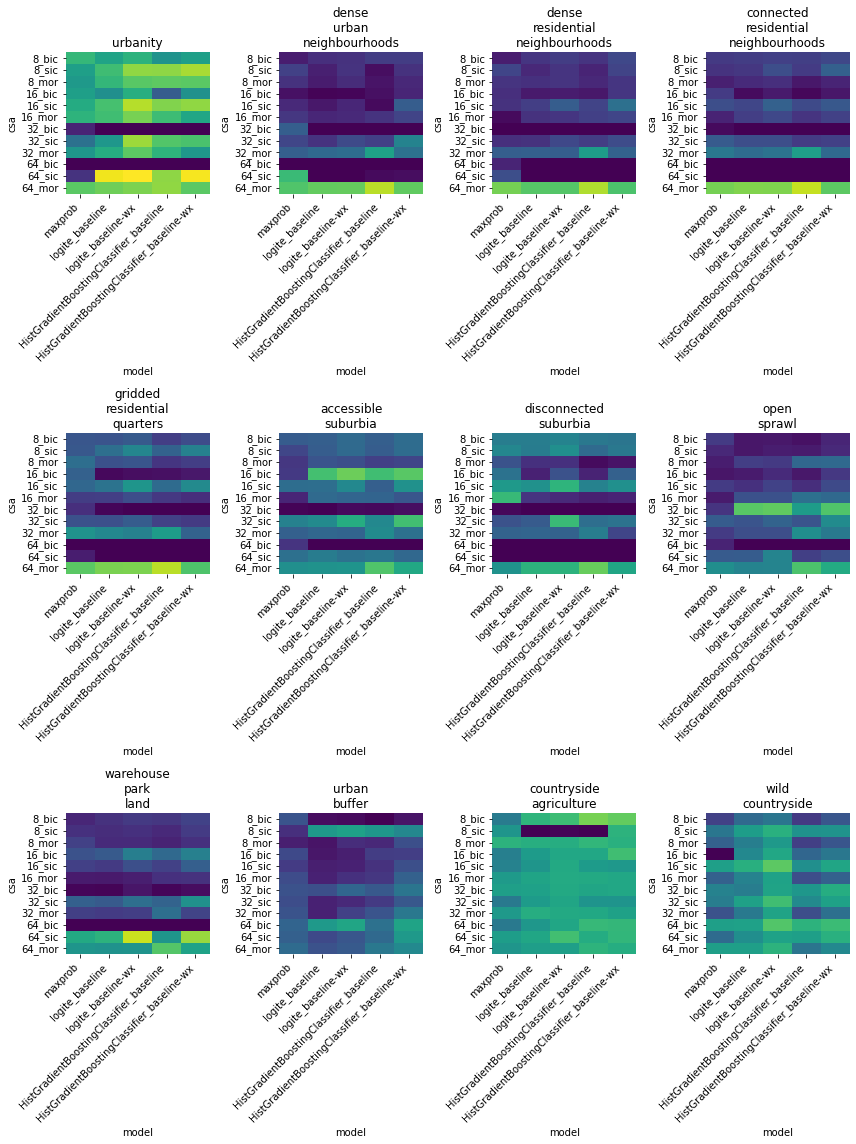

In [42]:
tmp = pandas.DataFrame(cba.stack().tolist(), cba.stack().index)
f, axs = plt.subplots(3, 4, figsize=(12, 16))
axs = axs.flatten()

maxval = tmp.values.max()
for i, sig in enumerate(tmp):
    tab = tmp[sig].unstack().reindex(index=csa_order, columns=tools.models_order)
    h = sns.heatmap(
        tab,
        vmax=maxval,
        cbar=False,
        cmap='viridis',
        ax=axs[i]
    )
    h.set_xticklabels(h.get_xticklabels(), rotation = 45, ha="right")
    axs[i].set_title(sig.replace('_', '\n'))
plt.tight_layout()
plt.show()

#### Regression models

- Data preparation

In [43]:
wc_acc = []
for (csa, model), accs in cba.stack().iteritems():
    chipsize, arch = csa.split('_')
    algo = model.split('_')[0]
    w = int('wx' in model)
    cm = pandas.DataFrame(
        np.array(metrics[f'{chipsize}_{arch}_{model}']['perf_confusion_val']),
        metrics[f'{chipsize}_{arch}_{model}']['meta_class_names'],
        metrics[f'{chipsize}_{arch}_{model}']['meta_class_names']
    )
    wc_acc.append((
        pandas.DataFrame(
            {
                'acc': accs, 
                'chipsize_int': int(chipsize), 
                'arch': arch, 
                'algo': algo, 
                'w': w,
                'obs_1k': cm.sum(axis=1) / 1000,
                'obs_pct': cm.sum(axis=1) * 100 / cm.sum().sum()
            }
        ).reset_index()
        .rename(columns={'index': 'signature'})
    ))
wc_acc = pandas.concat(wc_acc)

- Baseline model

In [44]:
m1wc = sm.ols(
    'acc ~ signature + arch + chipsize_int + algo + w', wc_acc
).fit()
m1wc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    acc   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     40.95
Date:                Tue, 23 Aug 2022   Prob (F-statistic):           5.01e-93
Time:                        16:58:28   Log-Likelihood:                 178.37
No. Observations:                 720   AIC:                            -320.7
Df Residuals:                     702   BIC:                            -238.3
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             0.1866      0.031      6.053      0.000       0.126       0.247
signature[T.connected_residential_neighbourhoods]    -0.1306      0.035     -3.738      0.000      -0.199      -0.062
signature[T.countryside_agriculture]                  0.2236      0.035      6.402      0.000       0.155       0.292
signature[T.dense_residential_neighbourhoods]        -0.1414      0.035     -4.048      0.000      -0.210      -0.073
signature[T.dense_urban_neighbourhoods]              -0.1420      0.035     -4.067      0.000      -0.211      -0.073
signature[T.disconnected_suburbia]                   -0.0601      0.035     -1.720      0.086      -0.129       0.008
signature[T.gridded_residential_quarters]            -0.0785      0.035     -2.247      0.025      -0.147      -0.010
signature[T.open_sprawl]                             -0.0845      0.035     -2.420      0.016      -0.153      -0.016
signature[T.urban_buffer]                            -0.0828      0.035     -2.372      0.018      -0.151      -0.014
signature[T.urbanity]                                 0.2358      0.035      6.752      0.000       0.167       0.304
signature[T.warehouse_park_land]                     -0.0857      0.035     -2.453      0.014      -0.154      -0.017
signature[T.wild_countryside]                         0.3876      0.035     11.099      0.000       0.319       0.456
arch[T.mor]                                           0.1753      0.017     10.037      0.000       0.141       0.210
arch[T.sic]                                           0.1202      0.017      6.886      0.000       0.086       0.155
algo[T.logite]                                       -0.0125      0.016     -0.786      0.432      -0.044       0.019
algo[T.maxprob]                                      -0.0188      0.021     -0.891      0.373      -0.060       0.023
chipsize_int                                          0.0014      0.000      4.215      0.000       0.001       0.002
w                                                     0.0365      0.016      2.290      0.022       0.005       0.068
==============================================================================
Omnibus:                       33.960   Durbin-Watson:                   1.470
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.924
Skew:                           0.411   Prob(JB):                     3.92e-11
Kurtosis:                       3.960   Cond. No.                         460.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- Absolute imbalance model

In [45]:
m2wc = sm.ols(
    'acc ~ signature + arch + chipsize_int + algo + w + obs_1k', wc_acc
).fit()
m2wc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    acc   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     60.59
Date:                Tue, 23 Aug 2022   Prob (F-statistic):          1.73e-129
Time:                        16:58:28   Log-Likelihood:                 268.17
No. Observations:                 720   AIC:                            -498.3
Df Residuals:                     701   BIC:                            -411.3
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                            -0.0237      0.031     -0.764      0.445      -0.085       0.037
signature[T.connected_residential_neighbourhoods]    -0.0726      0.031     -2.334      0.020      -0.134      -0.012
signature[T.countryside_agriculture]                  0.1593      0.031      5.109      0.000       0.098       0.221
signature[T.dense_residential_neighbourhoods]        -0.0836      0.031     -2.685      0.007      -0.145      -0.022
signature[T.dense_urban_neighbourhoods]              -0.1075      0.031     -3.473      0.001      -0.168      -0.047
signature[T.disconnected_suburbia]                   -0.0103      0.031     -0.332      0.740      -0.071       0.051
signature[T.gridded_residential_quarters]            -0.0127      0.031     -0.409      0.683      -0.074       0.049
signature[T.open_sprawl]                             -0.0995      0.031     -3.222      0.001      -0.160      -0.039
signature[T.urban_buffer]                            -0.1382      0.031     -4.445      0.000      -0.199      -0.077
signature[T.urbanity]                                 0.2022      0.031      6.536      0.000       0.141       0.263
signature[T.warehouse_park_land]                     -0.0788      0.031     -2.554      0.011      -0.139      -0.018
signature[T.wild_countryside]                         0.3283      0.031     10.545      0.000       0.267       0.389
arch[T.mor]                                           0.2512      0.016     15.376      0.000       0.219       0.283
arch[T.sic]                                          -0.0783      0.021     -3.747      0.000      -0.119      -0.037
algo[T.logite]                                       -0.0125      0.014     -0.889      0.374      -0.040       0.015
algo[T.maxprob]                                      -0.0188      0.019     -1.008      0.314      -0.055       0.018
chipsize_int                                          0.0041      0.000     11.669      0.000       0.003       0.005
w                                                     0.0365      0.014      2.592      0.010       0.009       0.064
obs_1k                                                0.0514      0.004     14.093      0.000       0.044       0.059
==============================================================================
Omnibus:                      123.681   Durbin-Watson:                   1.683
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              259.667
Skew:                           0.960   Prob(JB):                     4.11e-57
Kurtosis:                       5.229   Cond. No.                         462.
==============================================================================

Notes:
[1] S

- Relative imbalance model

In [46]:
m3wc = sm.ols(
    'acc ~ signature + arch + chipsize_int + algo + w + obs_pct', wc_acc
).fit()
m3wc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    acc   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.569
Method:                 Least Squares   F-statistic:                     53.64
Date:                Tue, 23 Aug 2022   Prob (F-statistic):          1.23e-118
Time:                        16:58:28   Log-Likelihood:                 242.10
No. Observations:                 720   AIC:                            -446.2
Df Residuals:                     701   BIC:                            -359.2
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             0.0595      0.030      1.965      0.050     4.2e-05       0.119
signature[T.connected_residential_neighbourhoods]    -0.0754      0.032     -2.330      0.020      -0.139      -0.012
signature[T.countryside_agriculture]                  0.1118      0.033      3.349      0.001       0.046       0.177
signature[T.dense_residential_neighbourhoods]        -0.0983      0.032     -3.052      0.002      -0.161      -0.035
signature[T.dense_urban_neighbourhoods]              -0.0998      0.032     -3.099      0.002      -0.163      -0.037
signature[T.disconnected_suburbia]                   -0.0019      0.032     -0.060      0.952      -0.065       0.062
signature[T.gridded_residential_quarters]            -0.0049      0.033     -0.151      0.880      -0.069       0.059
signature[T.open_sprawl]                             -0.1143      0.032     -3.563      0.000      -0.177      -0.051
signature[T.urban_buffer]                            -0.1753      0.033     -5.318      0.000      -0.240      -0.111
signature[T.urbanity]                                 0.2574      0.032      8.033      0.000       0.194       0.320
signature[T.warehouse_park_land]                     -0.0817      0.032     -2.555      0.011      -0.145      -0.019
signature[T.wild_countryside]                         0.2925      0.033      8.862      0.000       0.228       0.357
arch[T.mor]                                           0.1753      0.016     10.958      0.000       0.144       0.207
arch[T.sic]                                           0.1202      0.016      7.517      0.000       0.089       0.152
algo[T.logite]                                       -0.0125      0.015     -0.858      0.391      -0.041       0.016
algo[T.maxprob]                                      -0.0188      0.019     -0.972      0.331      -0.057       0.019
chipsize_int                                          0.0014      0.000      4.602      0.000       0.001       0.002
w                                                     0.0365      0.015      2.500      0.013       0.008       0.065
obs_pct                                               0.0156      0.001     11.651      0.000       0.013       0.018
==============================================================================
Omnibus:                       83.687   Durbin-Watson:                   1.454
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              128.339
Skew:                           0.796   Prob(JB):                     1.35e-28
Kurtosis:                       4.321   Cond. No.                         468.
==============================================================================

Notes:
[1] S

## Regression table(s)

In [47]:
summary_col([m1, m2, m3, m4, m1wc, m2wc, m3wc], stars=True)

,kappa I,model_accuracy I,macro_f1_w I,macro_f1_avg I,acc I,acc II,acc III
Intercept,0.2185***,0.3236***,0.2790***,0.1798***,0.1866***,-0.0237,0.0595**
,(0.0209),(0.0175),(0.0174),(0.0375),(0.0308),(0.0311),(0.0303)
R-squared,0.7214,0.8281,0.8514,0.4191,0.4979,0.6087,0.5794
R-squared Adj.,0.6899,0.8086,0.8346,0.3533,0.4857,0.5987,0.5686
algo[T.logite],-0.0245,-0.0256*,-0.0324**,-0.0325,-0.0125,-0.0125,-0.0125
,(0.0168),(0.0141),(0.0141),(0.0302),(0.0159),(0.0141),(0.0146)
algo[T.maxprob],-0.0559**,-0.0606***,-0.0421**,-0.0296,-0.0188,-0.0188,-0.0188
,(0.0222),(0.0187),(0.0186),(0.0399),(0.0211),(0.0186),(0.0193)
arch[T.mor],0.0227,-0.0357**,-0.0278*,0.1787***,0.1753***,0.2512***,0.1753***
,(0.0184),(0.0155),(0.0154),(0.0331),(0.0175),(0.0163),(0.0160)


To do:

- [ ] Confusion matrices colored by chip size, with different `cmap` by chip size to emphasise they're not comparable
- [x] Regression for within-class accuracy including dummy for class and measure of (im)balance
- [ ] Regression for spatial scores

## Spatial scores

- [ ] ~~Moran~~ (conceptually inappropriate)
- [ ] Joint Counts
- [ ] ~~Quadrat~~ (too memory intensive and less relevant)
- [x] Ripley's G
- [ ] ~~Ripley's F~~
- [x] Ripley's K

### Computation

Notes from running experiments on the spatial scores:
- Point pattern stats run consistently a lot faster
- Moran throws divide by zero error, which is a consequence of trying a statistic on a binary (0/1) dataset
- The `union` W is consistently much faster than the `thr`. This is to be expected, but the computational burden is noticeable.

All the above is steering into the direction of dropping both Moran and JC. The latter on conceptual grounds, the former on computational ones.

We will be running things in parallel, so we set up Dask first:

In [8]:
from dask import bag as dbag
from dask.distributed import Client, LocalCluster, as_completed

n_workers = 8
client = Client(LocalCluster(n_workers=n_workers))

2022-10-06 12:27:32,627 - distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/work/code/signature_ai/ai_experiments/dask-worker-space/worker-vb6zo1xf', purging
2022-10-06 12:27:32,628 - distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/work/code/signature_ai/ai_experiments/dask-worker-space/worker-g6yke44s', purging


All the spatial scores are calculated for each pair of chip size and architecture values. We will spread each of these across workers, so we first split the dataset up and send to Dask for computation: 

In [30]:
%%time
tasks = [(
    db.query(
        f'(split == "ml_val") & (chipsize_arch == "{csa}")'
    ).drop(columns=['split', 'chipsize_arch']), csa, None, 'label'
) for csa in tools.csa_order]

sp_metrics = pandas.concat(
    dbag.from_sequence(tasks).map(tools.sp_process_csa).compute(),
    ignore_index=True
)

/opt/conda/lib/python3.9/site-packages/pointpats/distance_statistics.py:281: RuntimeWarning: invalid value encountered in true_divide
  fracs = numpy.cumsum(counts) / counts.sum()
/opt/conda/lib/python3.9/site-packages/pointpats/random.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  intensity = n_observations / _area(hull)
/opt/conda/lib/python3.9/site-packages/pointpats/distance_statistics.py:436: RuntimeWarning: divide by zero encountered in double_scalars
  intensity = n / _area(hull)
/opt/conda/lib/python3.9/site-packages/pointpats/random.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  intensity = n_observations / _area(hull)
2022-10-06 12:48:53,267 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 5.52 GiB -- Worker memory limit: 7.81 GiB

CPU times: user 24.6 s, sys: 2.69 s, total: 27.3 s
Wall time: 1min 38s


**NOTE** - Results confirmed to match those on single-core.

This returns the raw spatial scores for the pattern relating to each set of predictions and observed values. What we are interested in however is the difference between predicted patterns and observed ones. To get at that, we calculate the difference between predicted and observed scores for each set of predictions (i.e., proportion of the observed value that the difference between predicted and observed represents):

In [146]:
%%time
dists = sp_metrics.groupby(
    ['csa', 'signature', 'metric']
).apply(
    tools.score_distance
).reset_index().drop(columns='level_3')

CPU times: user 5.35 s, sys: 117 ms, total: 5.46 s
Wall time: 4.75 s


This contains results for each value in the G and K functions. Each of them however include five values, one for each distant point (`support`) at which the statistic is calculated. To summarise these, we average the fives values into a single one.

In [168]:
dists_avg = dists.assign(
    stat=dists['metric'].str[:-3]
).groupby(
    ['csa', 'signature', 'model', 'stat']
)['dist'].mean().reset_index()

dists_avg.head()

,csa,signature,model,stat,dist
0,16_bic,accessible_suburbia,HistGradientBoostingClassifier_baseline,ripley_g,0.043616
1,16_bic,accessible_suburbia,HistGradientBoostingClassifier_baseline,ripley_k,1527.532420
2,16_bic,accessible_suburbia,HistGradientBoostingClassifier_baseline-wx,ripley_g,0.021754
3,16_bic,accessible_suburbia,HistGradientBoostingClassifier_baseline-wx,ripley_k,127.271848
4,16_bic,accessible_suburbia,logite_baseline,ripley_g,0.055279


### Visualisations

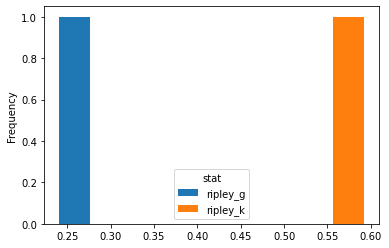

In [290]:
dists_avg.set_index(
    ['csa', 'signature', 'model']
).pivot(
    columns='stat', values='dist'
).query(
    '(ripley_g < 1) & (ripley_k < 1)'
).plot.hist();

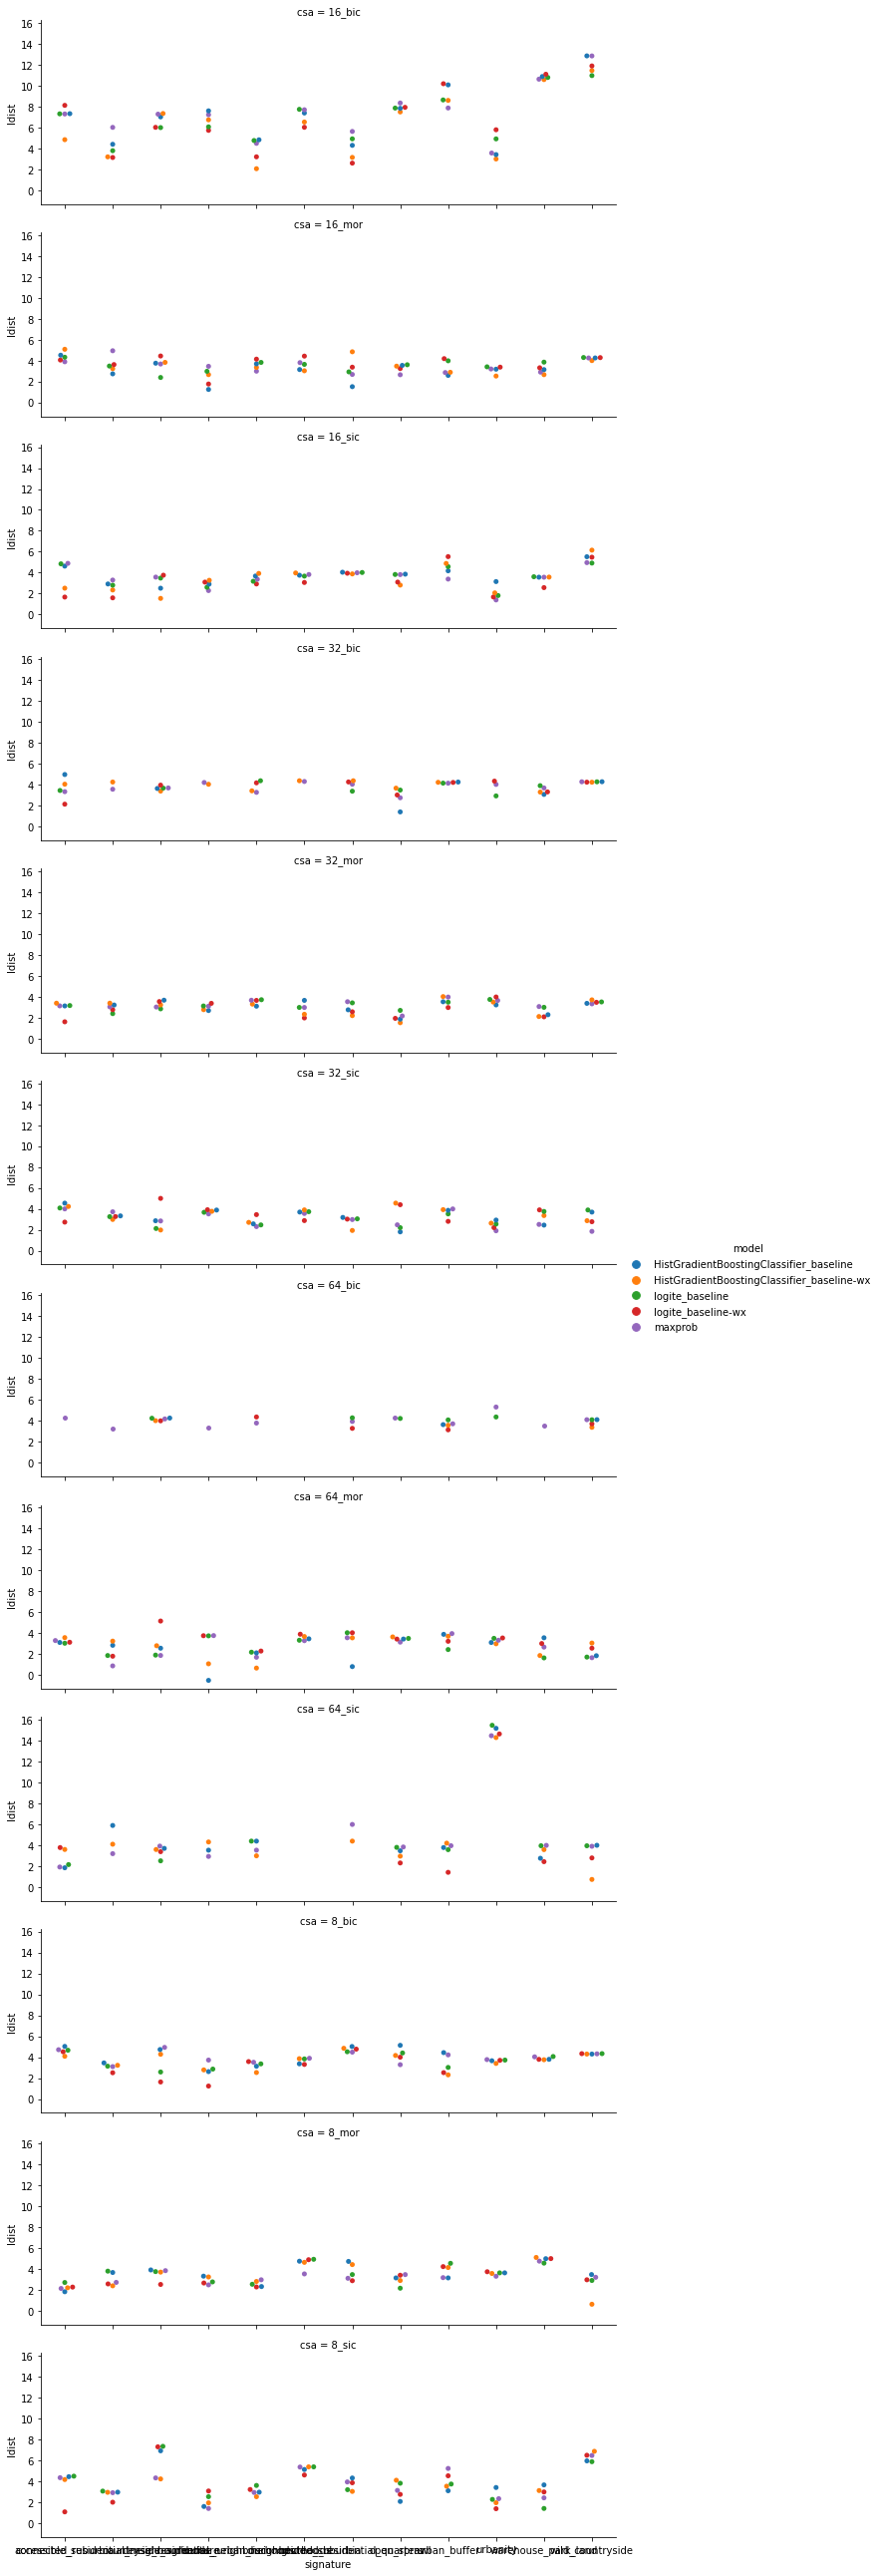

In [185]:
sns.catplot(
    data=dists_avg.assign(
        cs=dists_avg['csa'].str.
    ).assign(
        arch=
    ).assign(
        ldist=dists_avg.eval('log(dist)')
    ).query(
        "(stat == 'ripley_k') & (ldist < 20)"
    ),
    x='signature',
    y='ldist',
    hue='model',
    row='cs',
    col='arch',
    kind='swarm',
    aspect=3,
    height=3
);

### Regression models

We prepare the data for the different regressions, creating the features as required by the models (similar to the non-spatial performance regressions):

In [271]:
sp_dist_reg = dists_avg.query(
    '(stat == "ripley_k")'
).assign(
    chipsize_int=dists_avg['csa'].str.split('_').apply(
        lambda i: int(i[0])
    )
).assign(
    arch=dists_avg['csa'].str.split('_').apply(
        lambda i: i[1]
    )
).assign(
    algo=dists_avg['model'].str.split('_').apply(
        lambda i: i[0]
    )
).assign(
    w=dists_avg['model'].str.contains('wx').astype(int)
)

Here are regressions of the K function values. Six variants because there are a few very large outliers that skew the results. The first three columns are of the raw values, with increasing more restrictive set of data (without outliers), and the second three the same for the log of the scores.

In [268]:
m1s = sm.ols(
    'dist ~ signature + arch + chipsize_int + algo + w', sp_dist_reg
).fit()
m2s = sm.ols(
    'dist ~ signature + arch + chipsize_int + algo + w', sp_dist_reg, 
    subset=sp_dist_reg.query('dist < 2000').index
).fit()
m3s = sm.ols(
    'dist ~ signature + arch + chipsize_int + algo + w', sp_dist_reg, 
    subset=sp_dist_reg.query('dist < 200').index
).fit()
m4s = sm.ols(
    'np.log1p(dist) ~ signature + arch + chipsize_int + algo + w', sp_dist_reg
).fit()
m5s = sm.ols(
    'np.log1p(dist) ~ signature + arch + chipsize_int + algo + w', sp_dist_reg, 
    subset=sp_dist_reg.query('dist < 2000').index
).fit()
m6s = sm.ols(
    'np.log1p(dist) ~ signature + arch + chipsize_int + algo + w', sp_dist_reg, 
    subset=sp_dist_reg.query('dist < 200').index
).fit()
summary_col([m1s, m2s, m3s, m4s, m5s, m6s], stars=True)

,dist I,dist II,dist III,np.log1p(dist) I,np.log1p(dist) II,np.log1p(dist) III
Intercept,331164633106562688.0000,249.8576***,78.3515***,4.9244***,4.6007***,4.1780***
,(9923557301640667136.0000),(34.8834),(5.5500),(0.4813),(0.1669),(0.1376)
signature[T.connected_residential_neighbourhoods],1103017625372903808.0000,-92.1930**,-27.4337***,-0.5427,-0.5457***,-0.4744***
,(11434761718691575808.0000),(39.4725),(6.1544),(0.5546),(0.1889),(0.1526)
signature[T.countryside_agriculture],-1235409150874952960.0000,52.3812,-10.2322*,-0.0224,0.1347,-0.1038
,(10978784642688839680.0000),(37.9212),(6.0670),(0.5324),(0.1814),(0.1505)
signature[T.dense_residential_neighbourhoods],1103017625372906880.0000,-49.5042,-28.5430***,-0.4442,-0.5188***,-0.5875***
,(11434761718691575808.0000),(39.6807),(6.2570),(0.5546),(0.1899),(0.1552)
signature[T.dense_urban_neighbourhoods],-8460889287867641.0000,-100.4991***,-21.3348***,-0.5868,-0.5174***,-0.3387**
,(11210097030805184512.0000),(38.7092),(5.9780),(0.5437),(0.1852),(0.1483)


In [279]:
def sig_reg(tab):
    sig = tab['signature'].iloc[0]
    m = sm.ols(
        f'{sig} ~ arch + chipsize_int + algo + w', tab.rename(columns={'dist': sig})
    ).fit()
    return m

In [287]:
tst = sp_dist_reg.groupby('signature').apply(sig_reg)
summary_col(tst.tolist())

,accessible_suburbia,connected_residential_neighbourhoods,countryside_agriculture,dense_residential_neighbourhoods,dense_urban_neighbourhoods,disconnected_suburbia,gridded_residential_quarters,open_sprawl,urban_buffer,urbanity,warehouse_park_land,wild_countryside
Intercept,558.1675,70.9588,464.5939,502.2865,52.9239,34797140724871184384.0000,88.9902,944.3289,4347.1867,-367668.8743,16824.3724,75951.9887
,(189.7973),(29.4504),(141.3631),(130.5224),(9.6120),(80933024189194616832.0000),(25.3445),(279.0450),(1639.5352),(308098.3838),(4923.8792),(24922.1699)
arch[T.mor],-501.7014,-39.2084,-252.3160,-375.2700,-29.6390,-169437002068941570048.0000,-51.0421,-805.6683,-3224.1808,-154802.9277,-15156.1462,-53258.4009
,(176.6707),(27.2330),(124.7333),(120.6950),(8.3619),(70663670185847324672.0000),(21.5358),(254.1574),(1446.6623),(276388.8263),(4583.3389),(21990.3567)
arch[T.sic],-482.8451,-24.7828,-56.8494,-376.2274,-23.0453,-115296215421729964032.0000,-27.7289,-794.2032,-3197.2328,583880.2687,-15176.1702,-53063.3836
,(176.6707),(27.2760),(124.7333),(120.8855),(8.4465),(74258649331430981632.0000),(22.3249),(254.1574),(1446.6623),(276388.8263),(4583.3389),(21990.3567)
algo[T.logite],126.9022,-22.0863,8.9076,-93.9293,9.3134,67759176159609307136.0000,-15.5547,17.2374,131.5102,22023.7437,997.1454,-11427.2936
,(156.2399),(23.8894),(113.8654),(105.8764),(7.5324),(64605964712929607680.0000),(20.1620),(228.0784),(1320.6159),(244996.6948),(4053.3068),(20074.3574)
algo[T.maxprob],18.6485,3.0007,-28.2121,-92.6635,-8.6094,-43369928316265676800.0000,25.7083,114.3110,-942.2686,-261765.5039,-1420.0218,7654.2438
,(202.3199),(29.6662),(150.6298),(131.4787),(9.8079),(83040577116527493120.0000),(26.3129),(297.2463),(1747.0107),(316626.9263),(5248.7514),(26555.8787)


In [288]:
sp_dist_reg.groupby('signature').size()

signature
accessible_suburbia                     56
connected_residential_neighbourhoods    51
countryside_agriculture                 60
dense_residential_neighbourhoods        51
dense_urban_neighbourhoods              55
disconnected_suburbia                   51
gridded_residential_quarters            54
open_sprawl                             57
urban_buffer                            60
urbanity                                55
warehouse_park_land                     56
wild_countryside                        60
dtype: int64

Here are regressions of the K function values. Six variants because there are a few very large outliers that skew the results. The first three columns are of the raw values, with increasing more restrictive set of data (without outliers), and the second three the same for the log of the scores.

# DEPRECATED

---

Test to debug `spatial_perf`:

In [145]:
from importlib import reload
reload(tools);

In [133]:
tab = db.query(
    '(split == "ml_val") & (chipsize_arch == "8_bic")'
).drop(columns=['split', 'chipsize_arch'])
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    w_queen = weights.Queen.from_dataframe(tab, ids=range(len(tab)))
    w_k1 = weights.KNN.from_dataframe(tab, k=1, ids=range(len(tab)))
    w_union = weights.w_union(w_queen, w_k1)
    w_union.transform = 'r'
    #
    min_thr = weights.min_threshold_distance(
        np.array([tab.centroid.x, tab.centroid.y]).T
    )
    w_thr = weights.DistanceBand.from_dataframe(tab, min_thr)
# Coords
xys = tab.centroid
xys = np.array([xys.x, xys.y]).T

In [142]:
%%time
model = 'label'
csa = '8_bic'
tst = pandas.concat([
    tools.spatial_scores((
        tab[model], {'union': w_union, 'thr': w_thr}, xys, f'{csa}_{model}'
    )),
    tools.spatial_scores((
        tab['HistGradientBoostingClassifier_baseline'], 
        {'union': w_union, 'thr': w_thr}, xys, 
        f'{csa}_HistGradientBoostingClassifier_baseline'
    ))
])
    

CPU times: user 2.01 s, sys: 19 µs, total: 2.01 s
Wall time: 2 s


In [6]:
from importlib import reload
reload(tools);

In [5]:
%%time
tasks = [(
    db.query(
        f'(split == "ml_val") & (chipsize_arch == "{csa}")'
    )[['geometry', model]], f'{csa}_{model}'
) for csa in tools.csa_order for model in tools.models_order+['label']]

#sp_metrics = dbag.from_sequence(tasks).map(tools.spatial_perf).compute()

CPU times: user 4.89 s, sys: 0 ns, total: 4.89 s
Wall time: 4.63 s
